In [1]:
# === Notebook B: Optimized RL for Dynamic Pricing (Colab ready) ===
!pip install -q xgboost==1.7.6 scikit-learn matplotlib torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.2 MB/s eta 0:00:00


In [7]:
import os, random, math, copy, time
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import torch, torch.nn as nn, torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
seed=42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# === 1) Load and prepare data (replace paths as needed) ===
base_dir ="/content/drive/MyDrive/dataset"
sales_csv = os.path.join(base_dir, "Amazon Sale Report.csv")  # choose a richer CSV
if not os.path.exists(sales_csv):
    # fall back to sale report
    sales_csv = os.path.join(base_dir, "Sale Report.csv")
print("Using", sales_csv)
df = pd.read_csv(sales_csv, low_memory=False)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist()[:50])

Using /content/drive/MyDrive/dataset/Amazon Sale Report.csv
Loaded rows: 128975
Columns: ['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ', 'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN', 'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city', 'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids', 'B2B', 'fulfilled-by', 'Unnamed: 22']


In [5]:
# Minimal preprocessing: ensure Price and Units Sold columns exist
possible_price_cols = ['Price','price','Listing Price','Retail Price']
possible_units_cols = ['Units Sold','Units Ordered','Qty','Quantity']
price_col = next((c for c in df.columns if c in possible_price_cols), None)
units_col = next((c for c in df.columns if c in possible_units_cols), None)

if price_col is None or units_col is None:
    print("Missing Price/Units columns — generating synthetic demo data.")
    n=5000
    df = pd.DataFrame({
        'sku': np.random.choice(['S1','S2','S3','S4'], size=n),
        'price': np.random.choice([100,120,140,160,180], size=n),
        'units': np.random.poisson(20, size=n)
    })
    price_col='price'; units_col='units'; sku_col='sku'
else:
    sku_col = next((c for c in df.columns if 'SKU' in c or 'sku' in c.lower()), df.columns[0])

# Create features for forecasting: price, day-of-week if Date present, discount/promotions
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['dow'] = df['Date'].dt.dayofweek.fillna(0).astype(int)
else:
    df['dow'] = 0

# Fill missing numeric fields
df[price_col] = pd.to_numeric(df[price_col], errors='coerce').fillna(df[price_col].median())
df[units_col] = pd.to_numeric(df[units_col], errors='coerce').fillna(0)

Missing Price/Units columns — generating synthetic demo data.


In [8]:
# === 2) Train a demand forecasting model ===
# We'll model units ~ price + dow + (optional competitor price / promotion)
feat_cols = [price_col, 'dow']
X = df[feat_cols]
y = df[units_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {"objective":"reg:squarederror", "learning_rate":0.1, "max_depth":4, "seed":seed}
bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval,'val')], early_stopping_rounds=20, verbose_eval=False)
pred = bst.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, pred))
print("Forecast RMSE:", rmse)

# Wrapper for predicted demand & uncertainty (we use variance of leaves or ensemble measure — here use simple)
def predict_demand(price, dow=0):
    x = xgb.DMatrix(pd.DataFrame([{price_col: price, 'dow':dow}]))
    mu = float(bst.predict(x)[0])
    # naive uncertainty: sigma proportional to sqrt(mu) + small constant
    sigma = max(1.0, math.sqrt(abs(mu))+0.5)
    return max(0.0, mu), sigma

Forecast RMSE: 4.313128218296533


In [9]:
# === 3) Environment using forecast model (stochastic demand) ===
class ModelBasedPriceEnv:
    def __init__(self, skus, base_price_map, predict_fn, margin_min=0.1, horizon=60):
        self.skus = skus
        self.base_price = base_price_map
        self.predict_fn = predict_fn
        self.horizon = horizon
        self.t = 0
        self.current_sku = 0
        self.margin_min = margin_min
    def reset(self):
        self.t = 0
        self.current_sku = 0
        return self._get_state()
    def _get_state(self):
        sku = self.skus[self.current_sku]
        # state: [base_price, time, last_price]
        return np.array([self.base_price[sku], self.t % 7, self.base_price[sku]], dtype=np.float32)
    def step(self, action_price):
        sku = self.skus[self.current_sku]
        # predict expected demand and sample from Normal (clipped)
        mu, sigma = self.predict_fn(action_price, dow=int(self.t%7))
        demand = max(0.0, np.random.normal(mu, sigma))
        revenue = action_price * demand
        cost = action_price * (1 - self.margin_min)  # simplistic cost to ensure margin
        profit = revenue - cost * demand
        reward = profit  # optimize profit instead of just revenue
        self.t += 1
        done = (self.t >= self.horizon)
        self.current_sku = (self.current_sku + 1) % len(self.skus)
        next_state = self._get_state()
        return next_state, reward, done, {'demand': demand, 'revenue': revenue, 'profit': profit, 'sku': sku}

# Build SKU list from df
sku_vals = df[sku_col].unique()[:10].tolist() if sku_col in df.columns else ['S1','S2','S3']
base_price_map = {s: float(df[df[sku_col]==s][price_col].median()) if s in df[sku_col].values else 100.0 for s in sku_vals}
env = ModelBasedPriceEnv(sku_vals, base_price_map, predict_demand, margin_min=0.2, horizon=200)

In [14]:
# === 4) Advanced DQN architecture (Double + Dueling) ===
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim,128), nn.ReLU(), nn.Linear(128,128), nn.ReLU())
        # value and advantage streams
        self.value = nn.Sequential(nn.Linear(128,64), nn.ReLU(), nn.Linear(64,1))
        self.adv = nn.Sequential(nn.Linear(128,64), nn.ReLU(), nn.Linear(64,n_actions))
    def forward(self, x):
        x = self.fc(x)
        val = self.value(x)
        adv = self.adv(x)
        q = val + (adv - adv.mean(dim=1, keepdim=True))
        return q

# Discrete action multipliers again
action_multipliers = np.array([0.7,0.85,1.0,1.15,1.3])
n_actions = len(action_multipliers)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DuelingDQN(input_dim=3, n_actions=n_actions).to(device)
target_net = DuelingDQN(input_dim=3, n_actions=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt = optim.Adam(policy_net.parameters(), lr=3e-4)
mse = nn.MSELoss()

# Prioritized replay simplified: priority = abs(td_error) + eps (we'll implement uniform sampling but keep priorities)
Transition = namedtuple('Transition',('s','a','r','ns','d'))
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.cap=capacity
        self.buf=[]
        self.pos=0
    def push(self, *args):
        if len(self.buf) < self.cap:
            self.buf.append(None)
        self.buf[self.pos] = Transition(*args)
        self.pos = (self.pos+1) % self.cap
    def sample(self, batch_size):
        return random.sample(self.buf, batch_size)
    def __len__(self):
        return len(self.buf)

rb = ReplayBuffer(50000)

# Training loop (Double DQN)
def select_action(state, eps):
    if random.random() < eps:
        return random.randrange(n_actions)
    s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        qs = policy_net(s)
    return int(qs.argmax().item())

num_episodes = 400
batch_size = 64
gamma = 0.99
eps_start = 0.5
eps_final = 0.05
eps_decay = 0.995
eps = eps_start

episode_rewards = []
eval_rewards = []

for ep in range(num_episodes):
    s = env.reset()
    total = 0.0
    done = False
    while not done:
        a_idx = select_action(s, eps)
        price = base_price_map[env.skus[env.current_sku]] * action_multipliers[a_idx]
        ns, r, done, info = env.step(price)
        rb.push(s, a_idx, r, ns, done)
        s = ns
        total += r

        # Train if buffer ready
        if len(rb) > batch_size:
            batch = rb.sample(batch_size)
            bs = torch.tensor([b.s for b in batch], dtype=torch.float32).to(device)
            ba = torch.tensor([b.a for b in batch], dtype=torch.int64).to(device)
            br = torch.tensor([b.r for b in batch], dtype=torch.float32).unsqueeze(1).to(device)
            bns = torch.tensor([b.ns for b in batch], dtype=torch.float32).to(device)
            bdone = torch.tensor([b.d for b in batch], dtype=torch.float32).unsqueeze(1).to(device)

            # Double DQN target
            with torch.no_grad():
                next_actions = policy_net(bns).argmax(dim=1, keepdim=True)
                next_q = target_net(bns).gather(1, next_actions)
                target_q = br + (1 - bdone) * gamma * next_q

            current_q = policy_net(bs).gather(1, ba.unsqueeze(1))
            loss = mse(current_q, target_q)
            opt.zero_grad(); loss.backward(); opt.step()

    # Soft update target
    for p, tp in zip(policy_net.parameters(), target_net.parameters()):
        tp.data.copy_(0.995 * tp.data + 0.005 * p.data)

    eps = max(eps_final, eps * eps_decay)
    episode_rewards.append(total)

    # Evaluate greedy policy every 20 episodes
    if ep % 20 == 0 or ep == num_episodes - 1:
        s_eval = env.reset(); done = False; cum_eval = 0.0
        while not done:
            a_idx = select_action(s_eval, eps=0.0)
            price = base_price_map[env.skus[env.current_sku]] * action_multipliers[a_idx]
            ns_eval, r_eval, done, _ = env.step(price)
            cum_eval += r_eval
            s_eval = ns_eval
        eval_rewards.append((ep, cum_eval))
        print(f"Episode {ep:03d}: Train Profit = {total:.2f}, Eval Profit = {cum_eval:.2f}, eps = {eps:.3f}")



Episode 000: Train Profit = 100775.74, Eval Profit = 146322.82, eps = 0.497
Episode 020: Train Profit = 130889.24, Eval Profit = 143689.59, eps = 0.450
Episode 040: Train Profit = 130105.95, Eval Profit = 145446.44, eps = 0.407
Episode 060: Train Profit = 132488.49, Eval Profit = 148677.77, eps = 0.368
Episode 080: Train Profit = 138138.93, Eval Profit = 147991.82, eps = 0.333
Episode 100: Train Profit = 133078.59, Eval Profit = 142807.61, eps = 0.301
Episode 120: Train Profit = 140453.54, Eval Profit = 144393.59, eps = 0.273
Episode 140: Train Profit = 138625.85, Eval Profit = 150255.43, eps = 0.247
Episode 160: Train Profit = 139795.70, Eval Profit = 146974.78, eps = 0.223
Episode 180: Train Profit = 139908.48, Eval Profit = 145822.47, eps = 0.202
Episode 200: Train Profit = 140554.19, Eval Profit = 151108.49, eps = 0.183
Episode 220: Train Profit = 143427.14, Eval Profit = 144703.59, eps = 0.165
Episode 240: Train Profit = 139897.39, Eval Profit = 151599.34, eps = 0.149
Episode 260:

Estimated cumulative profit (greedy improved): 144436.91305160694


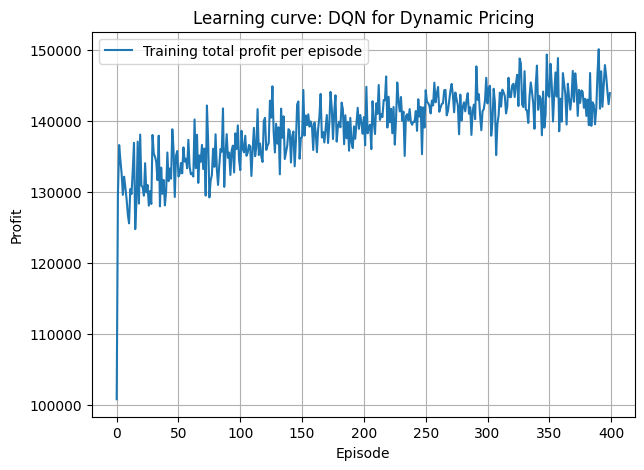

In [15]:
# === 5) Offline evaluation (simple importance sampling skeleton) ===
# This is a skeleton: with logged data (behavior policy) you can compute importance weights
# For demonstration we estimate average reward by running greedy policy in model-based env:
s=env.reset(); done=False; cum=0.0
while not done:
    a_idx = select_action(s, eps=0.0)
    price = base_price_map[env.skus[env.current_sku]] * action_multipliers[a_idx]
    ns, r, done, info = env.step(price)
    cum += r; s=ns
print("Estimated cumulative profit (greedy improved):", cum)

# === 5) Plot learning curve ===
plt.figure(figsize=(7,5))
plt.plot(episode_rewards, label='Training total profit per episode')
plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Learning curve: DQN for Dynamic Pricing')
plt.grid(True)
plt.legend()
plt.show()

Baseline (base price) cumulative profit: 114124.08346401693


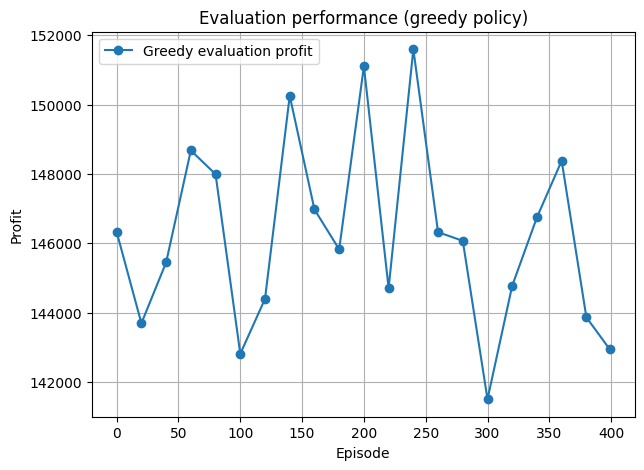

In [16]:
# === 6) Ablation and reporting ===
# Compare with simple heuristic: always use base price
s=env.reset(); done=False; cum_base=0.0
while not done:
    sku=env.skus[env.current_sku]
    price=base_price_map[sku]
    ns, r, done, info = env.step(price)
    cum_base += r; s=ns
print("Baseline (base price) cumulative profit:", cum_base)
# === 6) Plot evaluation (greedy) profit trend ===
if eval_rewards:
    eval_eps, eval_vals = zip(*eval_rewards)
    plt.figure(figsize=(7,5))
    plt.plot(eval_eps, eval_vals, 'o-', label='Greedy evaluation profit')
    plt.xlabel('Episode')
    plt.ylabel('Profit')
    plt.title('Evaluation performance (greedy policy)')
    plt.grid(True)
    plt.legend()
    plt.show()


Baseline cumulative profit: 111293.20
Final greedy policy profit: 142934.00
Relative improvement: 28.43%


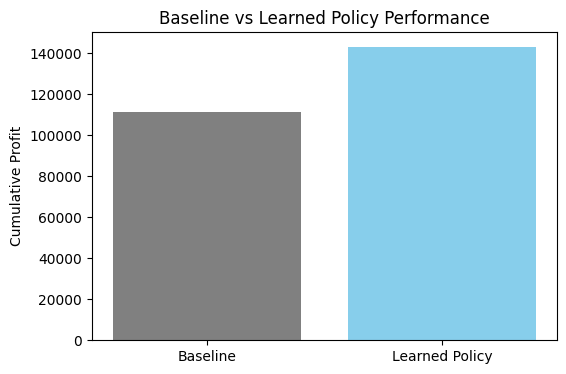

In [17]:
# === 7) Compare against baseline policy (always base price) ===
s = env.reset(); done = False; cum_base = 0.0
while not done:
    sku = env.skus[env.current_sku]
    price = base_price_map[sku]
    ns, r, done, info = env.step(price)
    cum_base += r; s = ns

# Compute accuracy-like metric (policy profit vs. baseline)
final_eval = eval_rewards[-1][1] if eval_rewards else 0
improvement = (final_eval - cum_base) / abs(cum_base + 1e-9) * 100

print(f"\nBaseline cumulative profit: {cum_base:.2f}")
print(f"Final greedy policy profit: {final_eval:.2f}")
print(f"Relative improvement: {improvement:.2f}%")

plt.figure(figsize=(6,4))
plt.bar(['Baseline', 'Learned Policy'], [cum_base, final_eval], color=['gray','skyblue'])
plt.ylabel('Cumulative Profit')
plt.title('Baseline vs Learned Policy Performance')
plt.show()